## Install Library
Kode di bawah ini akan menginstal library Python yang dibutuhkan:
- `networkx`: Untuk membuat struktur graf (Knowledge Graph).
- `matplotlib`: Untuk memvisualisasikan (menggambar) graf tersebut.
- `google-generativeai`: Untuk mengakses model AI Gemini guna analisis medis.

In [39]:
!pip install networkx matplotlib google-generativeai python-dotenv


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: C:\Users\NITRO 5\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## Persiapan Dataset
Kode di bawah ini berfungsi untuk:
1. Membaca file dataset `fhir_data_1000.json`.
2. Menghitung total pasien yang ada di dalam file tersebut.
3. Menampilkan 5 data pertama (head) untuk memastikan struktur data sudah benar dan terbaca dengan baik.

In [ ]:
import json
import os

# Nama file sesuai script generator tadi
FILENAME = os.getenv("FILENAME") 

try:
    with open(FILENAME, 'r') as f:
        bundle = json.load(f)
    
    total_pasien = 0
    entries = bundle.get('entry', [])
    for entry in entries:
        if entry['resource']['resourceType'] == 'Patient':
            total_pasien += 1
            
    print(f"✅ SUKSES! File terbaca.")
    print(f"📂 Jumlah Pasien dalam Database: {total_pasien} orang")
    
    print("\n5 Data Pertama (Head):")
    print(json.dumps(entries[:5], indent=2))
        
except FileNotFoundError:
    print(f"❌ ERROR: File '{FILENAME}' tidak ditemukan!")
    print("Pastikan file json ada di folder yang sama dengan notebook ini.")

✅ SUKSES! File terbaca.
📂 Jumlah Pasien dalam Database: 1000 orang

5 Data Pertama (Head):
[
  {
    "fullUrl": "urn:uuid:aa382b2d-c812-47ab-84df-4e2755a2ba77",
    "resource": {
      "resourceType": "Patient",
      "id": "aa382b2d-c812-47ab-84df-4e2755a2ba77",
      "identifier": [
        {
          "system": "https://fhir.kemkes.go.id/id/nik",
          "value": "3374931191263043"
        }
      ],
      "name": [
        {
          "use": "official",
          "text": "Dewi Wijaya"
        }
      ],
      "gender": "male",
      "birthDate": "1987-11-02"
    }
  },
  {
    "fullUrl": "urn:uuid:312438c4-834c-4ad7-bc60-7fd94d35dd1c",
    "resource": {
      "resourceType": "Observation",
      "id": "312438c4-834c-4ad7-bc60-7fd94d35dd1c",
      "status": "final",
      "category": [
        {
          "coding": [
            {
              "system": "http://terminology.hl7.org/CodeSystem/observation-category",
              "code": "vital-signs",
              "display": "Vit

## Parsing Data (Menjahit Hubungan) / ETL (Extract, Transform, Load)
Kode di bawah ini melakukan proses ETL **plus Preprocessing** untuk merapikan data mentah FHIR:
1. **Preprocessing**: Membersihkan teks (Title Case) dan memformat tanggal agar lebih mudah dibaca manusia.
2. **Extract**: Mengambil data Pasien dan Permintaan Obat (`MedicationRequest`) dari file JSON.
3. **Transform**: Menghubungkan ID acak (UUID) pasien dengan NIK mereka, lalu mengelompokkan obat-obatan ke pasien yang sesuai.
4. **Load**: Menyimpan hasil pengelompokan ke dalam dictionary `DATASET_RAPID` agar mudah diakses untuk visualisasi dan analisis AI.

In [41]:
import json
from datetime import datetime

def format_date(date_str):
    if not date_str: return "-"
    try:
        dt = datetime.fromisoformat(date_str)
        return dt.strftime("%d %b %Y")
    except:
        return date_str

def process_fhir_data_complete(filename):
    try:
        with open(filename, 'r') as f:
            bundle = json.load(f)
    except FileNotFoundError:
        print("❌ File tidak ditemukan!")
        return {}

    database = {}
    uuid_to_nik = {}
    entries = bundle.get('entry', [])
    
    # 1. Parsing Pasien
    for entry in entries:
        res = entry['resource']
        if res['resourceType'] == 'Patient':
            full_id = "urn:uuid:" + res['id']
            nik = res['identifier'][0]['value'] if 'identifier' in res else "UNKNOWN"
            nama = res['name'][0]['text']
            
            # Cek Alergi
            alergi = []
            if "extension" in res:
                for ext in res["extension"]:
                    if "allergy" in ext["url"]:
                        alergi = ext["valueString"].split(",")

            uuid_to_nik[full_id] = nik
            database[nik] = {
                "profil": {"nama": nama, "nik": nik, "alergi": alergi},
                "tanda_vital": {"tb": "-", "bb": "-", "tensi": "-"}, # Slot Vital Sign
                "medis": []
            }

    # 2. Parsing Observation (TB/BB/Tensi) -- BARU!
    for entry in entries:
        res = entry['resource']
        if res['resourceType'] == 'Observation':
            subject_ref = res['subject']['reference']
            if subject_ref in uuid_to_nik:
                nik_pemilik = uuid_to_nik[subject_ref]
                
                # Ambil kode LOINC
                code = res['code']['coding'][0]['code']
                
                # BB
                if code == "29463-7": 
                    val = res['valueQuantity']['value']
                    unit = res['valueQuantity']['unit']
                    database[nik_pemilik]['tanda_vital']['bb'] = f"{val} {unit}"
                
                # TB
                elif code == "8302-2":
                    val = res['valueQuantity']['value']
                    unit = res['valueQuantity']['unit']
                    database[nik_pemilik]['tanda_vital']['tb'] = f"{val} {unit}"
                
                # Tensi
                elif code == "85354-9":
                    try:
                        sys = res['component'][0]['valueQuantity']['value']
                        dia = res['component'][1]['valueQuantity']['value']
                        database[nik_pemilik]['tanda_vital']['tensi'] = f"{sys}/{dia} mmHg"
                    except:
                        pass

    # 3. Parsing Obat
    for entry in entries:
        res = entry['resource']
        if res['resourceType'] == 'MedicationRequest':
            subject_ref = res['subject']['reference']
            if subject_ref in uuid_to_nik:
                nik_pemilik = uuid_to_nik[subject_ref]
                
                nama_obat = res['medicationCodeableConcept']['coding'][0].get('display', 'Obat Misterius')
                diagnosa = res.get('reasonCode', [{}])[0].get('text', 'Tidak ada diagnosa')
                tanggal = format_date(res.get('authoredOn', ''))
                
                database[nik_pemilik]['medis'].append({
                    "obat": nama_obat,
                    "diagnosa": diagnosa,
                    "tanggal": tanggal
                })
                
    return database

# --- EKSEKUSI ---
FILENAME = '../fhir_data_1000.json'
DATASET_CLEAN = process_fhir_data_complete(FILENAME)

if DATASET_CLEAN:
    sample_nik = list(DATASET_CLEAN.keys())[0]
    print(f"✅ Data berhasil diload! Total: {len(DATASET_CLEAN)} pasien.")
    print(f"Sampel Vital Sign ({DATASET_CLEAN[sample_nik]['profil']['nama']}):")
    print(json.dumps(DATASET_CLEAN[sample_nik]['tanda_vital'], indent=2))

✅ Data berhasil diload! Total: 1000 pasien.
Sampel Vital Sign (Dewi Wijaya):
{
  "tb": "179 cm",
  "bb": "52 kg",
  "tensi": "124/79 mmHg"
}


## Visualisasi Knowledge Graph (Demo Factor)
Kode di bawah ini bertujuan untuk memvisualisasikan rekam medis pasien dalam bentuk **Knowledge Graph**:
- **Node Biru**: Pasien.
- **Node Merah**: Alergi yang dimiliki pasien.
- **Node Hijau**: Obat yang diresepkan.
- **Node Oranye**: Diagnosa penyakit.

Graf ini akan memudahkan kita melihat hubungan antara pasien, penyakit, dan obat-obatan secara visual.

Mencari pasien dengan data lengkap untuk visualisasi...


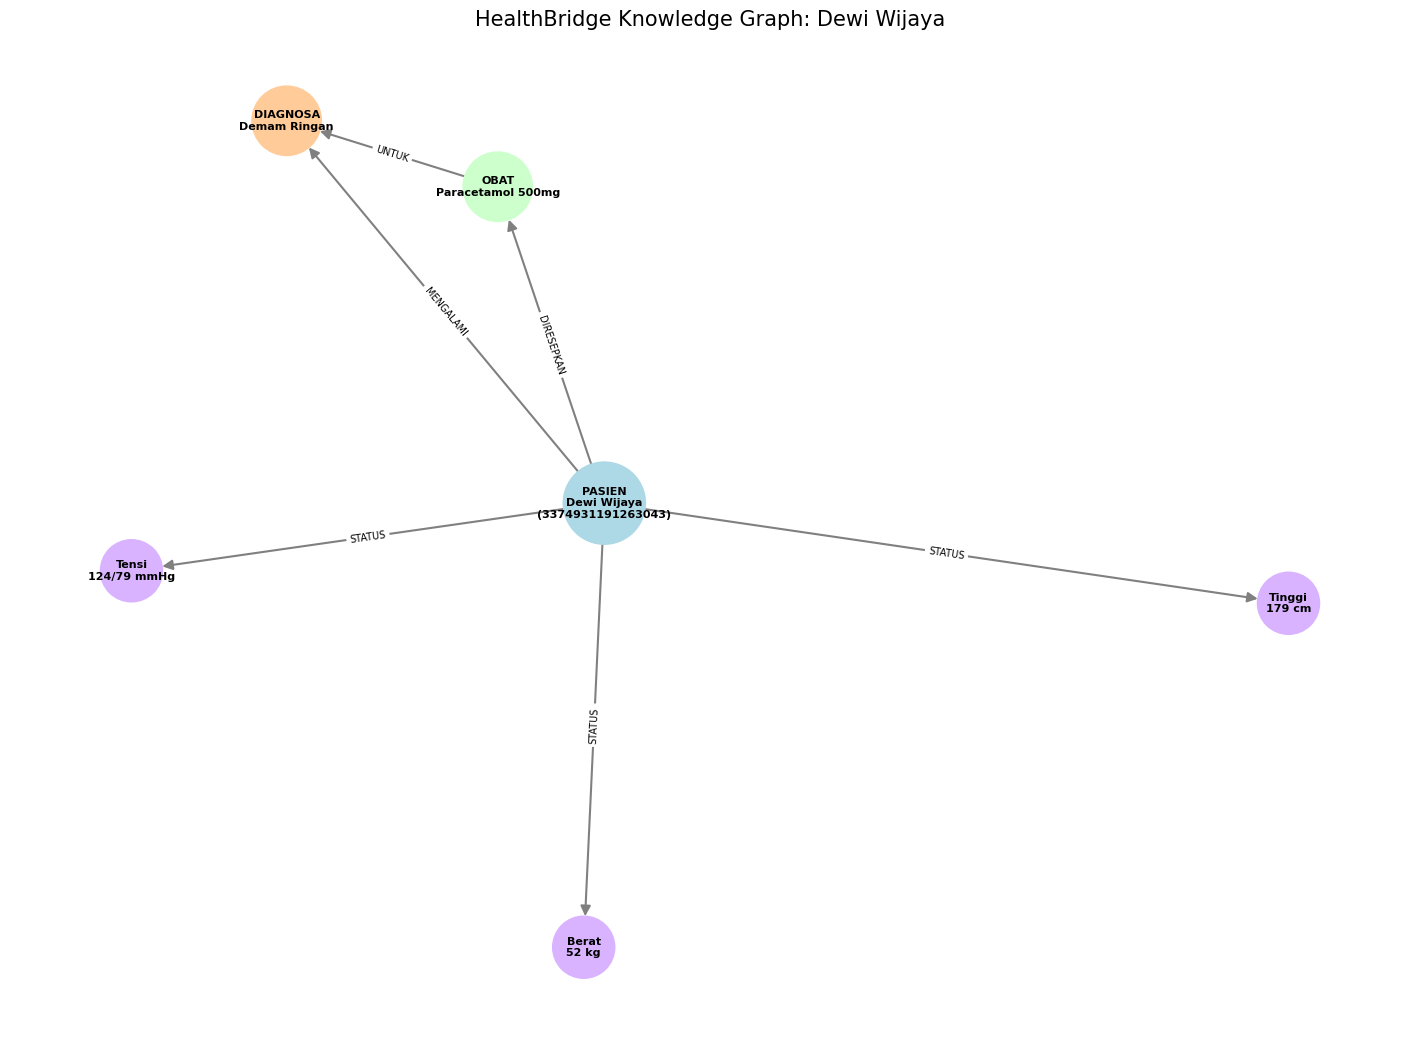

In [42]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_patient_graph_complete(nik_target):
    data = DATASET_CLEAN.get(nik_target)
    if not data:
        print(f"❌ Pasien NIK {nik_target} tidak ditemukan")
        return

    G = nx.DiGraph()
    
    # 1. Node Pusat: Pasien
    label_pasien = f"PASIEN\n{data['profil']['nama']}\n({data['profil']['nik']})"
    G.add_node(label_pasien, color='lightblue', node_size=3500)
    
    # 2. Node Alergi
    for alg in data['profil']['alergi']:
        label_alg = f"ALERGI\n{alg}"
        G.add_node(label_alg, color='#ffcccc', node_size=2000) # Merah Muda
        G.add_edge(label_pasien, label_alg, label="MEMILIKI")
        
    # 3. Node Tanda Vital (BARU!)
    vitals = data.get('tanda_vital', {})
    for k, v in vitals.items():
        if v != "-": # Hanya gambar jika datanya ada
            # Label dipercantik (tb -> Tinggi, bb -> Berat)
            nama_vital = "Tensi" if k == "tensi" else ("Tinggi" if k == "tb" else "Berat")
            label_vital = f"{nama_vital}\n{v}"
            
            G.add_node(label_vital, color='#d9b3ff', node_size=2000) # Ungu Muda
            G.add_edge(label_pasien, label_vital, label="STATUS")

    # 4. Node Obat & Diagnosa
    for medis in data['medis']:
        label_obat = f"OBAT\n{medis['obat']}"
        label_diag = f"DIAGNOSA\n{medis['diagnosa']}"
        
        # Node Obat
        G.add_node(label_obat, color='#ccffcc', node_size=2500) # Hijau Muda
        
        # Node Diagnosa
        G.add_node(label_diag, color='#ffcc99', node_size=2500) # Oranye Muda
        
        # Hubungan
        G.add_edge(label_pasien, label_obat, label="DIRESEPKAN")
        G.add_edge(label_obat, label_diag, label="UNTUK")
        G.add_edge(label_pasien, label_diag, label="MENGALAMI")

    # --- GAMBAR GRAPH ---
    plt.figure(figsize=(14, 10)) # Ukuran gambar lebih besar
    pos = nx.spring_layout(G, k=0.6, seed=42) # Layout rapi
    
    colors = [nx.get_node_attributes(G, 'color').get(node, 'lightgray') for node in G.nodes()]
    sizes = [nx.get_node_attributes(G, 'node_size').get(node, 1500) for node in G.nodes()]
    
    nx.draw(G, pos, with_labels=True, node_color=colors, node_size=sizes, 
            edge_color='gray', width=1.5, font_size=8, font_weight='bold', 
            arrows=True, arrowsize=15)
    
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)
    
    plt.title(f"HealthBridge Knowledge Graph: {data['profil']['nama']}", fontsize=15)
    plt.axis('off') # Hilangkan border kotak
    plt.show()

# --- EKSEKUSI ---
# Cari pasien yang punya data lengkap (obat + vital) untuk didemokan
print("Mencari pasien dengan data lengkap untuk visualisasi...")
for nik, val in DATASET_CLEAN.items():
    # Cari yang punya obat DAN punya tensi
    if len(val['medis']) > 0 and val['tanda_vital']['tensi'] != "-":
        visualize_patient_graph_complete(nik)
        break

## AI ANALYZER (Analisis Konflik Obat)
Bagian ini akan menggunakan AI (Google Gemini) untuk menganalisis data pasien yang sudah dirapikan.
AI akan bertindak sebagai asisten apoteker senior untuk:
1. Mengecek apakah ada **interaksi obat** yang berbahaya (Polypharmacy).
2. Memastikan obat yang diberikan aman terhadap **alergi** pasien.
3. Memberikan rekomendasi klinis.

In [43]:
import google.generativeai as genai
import json
import os
from dotenv import load_dotenv

load_dotenv()
API_KEY = os.getenv("GOOGLE_API_KEY")

if API_KEY:
    genai.configure(api_key=API_KEY)
    model = genai.GenerativeModel('gemini-2.0-flash') # Pakai model terbaru
else:
    print("❌ API Key tidak ditemukan!")

def analyze_risk_complete(nik_target):
    if 'DATASET_CLEAN' not in globals():
        print("❌ Error: Jalankan dulu Cell 3!")
        return

    data = DATASET_CLEAN.get(nik_target)
    if not data:
        print(f"❌ Pasien NIK {nik_target} tidak ditemukan.")
        return

    # Kirim data lengkap (Profil + Vital + Medis) ke AI
    context = json.dumps(data, indent=2)
    
    prompt = f"""
    Bertindaklah sebagai Asisten Medis AI untuk Dokter.
    
    DATA PASIEN LENGKAP:
    {context}
    
    TUGAS:
    1. RINGKASAN KLINIS: Rangkum biodata & tanda vital (TB/BB/Tensi) agar dokter cepat paham.
    2. ANALISIS KEAMANAN: Cek apakah obat cocok dengan kondisi (misal: Hipertensi tapi tensi masih tinggi?). Cek Interaksi Obat.
    
    OUTPUT JSON SAJA:
    {{
      "status": "AMAN" | "BAHAYA" | "PERINGATAN",
      "skor_risiko": 0-100,
      "ringkasan_pasien": "Ringkasan teks...",
      "analisis_obat": "Penjelasan klinis...",
      "rekomendasi": "Saran untuk dokter..."
    }}
    """
    
    print(f"🤖 AI sedang menganalisa {data['profil']['nama']} (Lengkap dengan Vital Sign)...")
    try:
        response = model.generate_content(prompt)
        # Bersihkan output
        clean_text = response.text.replace('```json', '').replace('```', '').strip()
        print(clean_text)
    except Exception as e:
        print(f"Error AI: {e}")

# --- EKSEKUSI ---
if 'DATASET_CLEAN' in globals() and DATASET_CLEAN:
    sample_nik = list(DATASET_CLEAN.keys())[0]
    analyze_risk_complete(sample_nik)

🤖 AI sedang menganalisa Dewi Wijaya (Lengkap dengan Vital Sign)...
{
  "status": "PERINGATAN",
  "skor_risiko": 60,
  "ringkasan_pasien": "Pasien Dewi Wijaya, tinggi badan 179 cm, berat badan 52 kg (BMI 16.2, Kurus), tekanan darah 124/79 mmHg. Riwayat alergi tidak tercatat. Pernah didiagnosa demam ringan dan diberikan Paracetamol 500mg pada 24 Nov 2025.",
  "analisis_obat": "Paracetamol umumnya aman untuk demam ringan. Namun, perlu diperhatikan berat badan pasien yang tergolong kurus (BMI 16.2). Dosis perlu disesuaikan dengan berat badan untuk menghindari efek samping. Tekanan darah pasien 124/79 mmHg, yang masuk kategori prehipertensi. Paracetamol jarang berinteraksi signifikan dengan obat lain, namun perlu ditanyakan apakah pasien sedang mengonsumsi obat lain secara rutin. Perhatikan potensi hepatotoksisitas jika pasien memiliki riwayat gangguan hati atau mengonsumsi alkohol secara teratur.",
  "rekomendasi": "1. Periksa fungsi hati pasien, terutama jika ada riwayat gangguan hati ata